In [ ]:
%%capture
!sudo apt-get update
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torchvision
from tqdm import tqdm
import copy
from google.colab import files
import pickle

from torch.utils.data import TensorDataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
from matplotlib.pyplot import figure

def non_latex_format():
  mpl.rcParams.update(mpl.rcParamsDefault)

  matplotlib.rcParams['pdf.fonttype'] = 42
  matplotlib.rcParams['ps.fonttype'] = 42
  plt.rcParams['figure.figsize'] = (16, 9)
  fontsize = 26
  matplotlib.rcParams.update({'font.size': fontsize})

def latex_format():
  plt.rcParams.update({
      'font.size': 10,
      'text.usetex': True,
      'text.latex.preamble': r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{amsfonts}\usepackage{bm}'
  })
  mpl.rc('font',family='Times New Roman')
  matplotlib.rcParams['pdf.fonttype'] = 42
  matplotlib.rcParams['ps.fonttype'] = 42
  plt.rcParams['figure.figsize'] = (16, 9)
  fontsize = 30
  matplotlib.rcParams.update({'font.size': fontsize})


latex_format()

In [ ]:
criterion = nn.CrossEntropyLoss() # supervised classification loss
criterion_nonreduced = nn.CrossEntropyLoss(reduce=False) # supervised classification loss

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


# Setup

In [ ]:
# LENET parameters
RANDOM_SEED = 214748364
SUBSET_SIZE = 50000
TEST_SUBSET_SIZE = 10000
N_ITERS = 1000000
BATCH_SIZE = 250
BATCH_SIZE_TEST = 1000

IMG_SIZE = 32
N_CLASSES = 10

#Set to zero to disconnect L2.
weight_decay = 0.02

# Data

In [ ]:
# setup devices
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.manual_seed(RANDOM_SEED)
else:
    device = torch.device("cpu")

In [ ]:
!nvidia-smi

Wed Jan 17 08:48:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
transforms = torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                             #torchvision.transforms.Normalize((0., 0., 0.,), (1., 1., 1.)),
])

transforms_translations = torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                             #torchvision.transforms.Normalize((0., 0., 0.,), (1., 1., 1.)),
                                             torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                             torchvision.transforms.RandomAffine(degrees = 0, translate = (0.05, 0.05)),
])

transforms_cropping_translations = torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                             #torchvision.transforms.Normalize((0., 0., 0.,), (1., 1., 1.)),
                                             #torchvision.transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE),  scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                                             torchvision.transforms.RandomAffine(degrees = 20, translate =(0.05, 0.05)),

])

In [ ]:

train_dataset = datasets.CIFAR10(root='cifar_data',
                                train=True,
                                transform=transforms,
                                download=True)

train_dataset_da = datasets.CIFAR10(root='cifar_data',
                                train=True,
                                transform=transforms_cropping_translations,
                                download=True)


test_dataset = datasets.CIFAR10(root='cifar_data',
                                train=False,
                                transform=transforms)


test_dataset_translations = datasets.CIFAR10(root='cifar_data',
                                train=False,
                                transform=transforms_translations)


test_dataset_translations_cropping = datasets.CIFAR10(root='cifar_data',
                                train=False,
                                transform=transforms_cropping_translations)

100%|██████████| 170498071/170498071 [00:03<00:00, 43436492.94it/s]


Extracting cifar_data/cifar-10-python.tar.gz to cifar_data
Files already downloaded and verified


# Model

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout = 0.0):
        super(MLP, self).__init__()
        self.dropout_value = dropout
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout_f = nn.Dropout(p=self.dropout_value, inplace = False)

    def forward(self, x):
        x = self.flatten(x)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        return x


In [ ]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class InceptionModule(nn.Module):

    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )

        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()

        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)

class InceptionNet(nn.Module):
    def __init__(self, num_classes, input_channels):
        super().__init__()

        self.conv1 = ConvModule(in_channels =input_channels,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [ ]:
SKIP=False
lambdas = np.arange(-10, 10, 0.01)

def train(model, train_loader, lr):

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    #optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95, verbose = False)

    data_iter = iter(train_loader)

    iters_per_epoch = len(data_iter)
    tq = tqdm(range(N_ITERS))

    aux_loss = 1

    for it in tq:

            model.train()

            try:
                inputs, target = next(data_iter)
            except StopIteration:
                # StopIteration is thrown if dataset ends
                # reinitialize data loader
                data_iter = iter(train_loader)
                inputs, target = next(data_iter)

            inputs = inputs.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            logits = model(inputs) # forward pass

            loss = criterion(logits, target) # supervised loss
            aux_loss += loss.detach().cpu().numpy()



            tq.set_postfix({'Train cce': loss.detach().cpu().numpy()})


            loss.backward() # computes gradients
            optimizer.step()

            if it % iters_per_epoch == 0:
              scheduler.step()
              if aux_loss/iters_per_epoch < 0.015:
                print("Early-stopping")
                break
              aux_loss = 0


    return model

# Load trained models

In [ ]:
with open(f"/content/drive/MyDrive/models/inception_standard.pickle", "rb") as handle:
  inception_standard = pickle.load(handle)
with open(f"/content/drive/MyDrive/models/inception_crop.pickle", "rb") as handle:
  inception_crop = pickle.load(handle)
with open(f"/content/drive/MyDrive/models/mlp.pickle", "rb") as handle:
  mlp = pickle.load(handle)
with open(f"/content/drive/MyDrive/models/inception_translations_rotations.pickle", "rb") as handle:
  inception_da = pickle.load(handle)

In [ ]:
def n_params(model):
  ret = 0
  for p in model.parameters():
    ret += len(p.flatten())
  return ret

In [ ]:
n_params(mlp)

2103818

In [ ]:
n_params(inception_standard)

1814106

In [ ]:
def eval(device, model, loader, criterion):
    correct = 0
    total = 0
    losses = []
    model.eval()
    with torch.no_grad():
        for data, targets in loader:
            total += targets.size(0)
            data = data.to(device)
            targets = targets.to(device)
            logits = model(data)
            probs = F.softmax(logits, dim=1)
            predicted = torch.argmax(probs, 1)
            correct += (predicted == targets).sum().detach().cpu().numpy()

            loss = criterion(logits, targets) # supervised loss
            losses.append(loss.detach().cpu().numpy())

    return correct, total, np.mean(losses), np.var(losses)

In [ ]:
g_cuda = torch.Generator(device='cpu')
g_cuda.manual_seed(RANDOM_SEED)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          generator=g_cuda,
                          shuffle=False )

In [ ]:
eval(device, inception_da, test_loader, criterion = nn.CrossEntropyLoss()) # supervised classification loss)

(8251, 10000, 0.528067, 0.0042111888)

In [ ]:
jet = plt.cm.get_cmap('Set2')
colors = {
    "Inception": jet(0),
    "Inception T": jet(1),
    "Inception TR": jet(2),
    "MLP": jet(3),
    "MLP T": jet(4),
    "MLP TR": jet(5),
}

<ipython-input-26-72f962552f4a>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap('Set2')


In [ ]:
markers = {
    "Inception": 8,
    "Inception-Crop": 9,
    "MLP": 10,
}

In [ ]:
def get_log_p(device, model, dataset, batch_size, size, repeat = 1):
    cce = nn.CrossEntropyLoss(reduction = "none") # supervised classification loss
    model.eval()
    aux = []
    rng = np.random.default_rng(RANDOM_SEED)
    with torch.no_grad():
      for _ in range(size):
          indexes = rng.choice(np.arange(len(dataset)), batch_size, replace = False)
          log_p = []
          for _ in range(repeat):
            data = []
            targets = []
            for i in indexes:
              d, t = dataset[i]
              data.append(d)
              targets.append(t)

            data = torch.stack(data)
            targets = torch.tensor(targets)

            data = data.to(device)
            targets = targets.to(device)
            logits = model(data)
            log_p.append(cce(logits, targets)) # supervised loss
          aux.append(torch.cat(log_p).mean(0).mean().detach().cpu().numpy())
    return np.array(aux)

In [ ]:
n = 1000
k=25

In [ ]:
mlp_log_p = get_log_p(device, mlp, test_dataset, 50, n, repeat = 1)
mlp_t_log_p = get_log_p(device, mlp, test_dataset_translations, 50, n, repeat = 1)
mlp_tc_log_p = get_log_p(device, mlp, test_dataset_translations_cropping, 50, n, repeat = 1)
mlp_tc_ad_log_p = get_log_p(device, mlp, test_dataset_translations_cropping, 50, n, repeat = k)

In [ ]:
np.savetxt("/content/drive/MyDrive/invariances/mlp_log_p.csv", mlp_log_p, delimiter=",")
np.savetxt("/content/drive/MyDrive/invariances/mlp_t_log_p.csv", mlp_t_log_p, delimiter=",")
np.savetxt("/content/drive/MyDrive/invariances/mlp_tc_log_p.csv", mlp_tc_log_p, delimiter=",")
np.savetxt("/content/drive/MyDrive/invariances/mlp_tc_ad_log_p.csv", mlp_tc_ad_log_p, delimiter=",")

In [ ]:
inception_log_p = get_log_p(device, inception_standard, test_dataset, 50, n, repeat = 1)
inception_t_log_p = get_log_p(device, inception_standard, test_dataset_translations, 50, n, repeat = 1)
inception_tc_log_p = get_log_p(device, inception_standard, test_dataset_translations_cropping, 50, n, repeat = 1)
inception_tc_ad_log_p = get_log_p(device, inception_standard, test_dataset_translations_cropping, 50, n, repeat = k)

In [ ]:
np.savetxt("/content/drive/MyDrive/invariances/inception_log_p.csv", inception_log_p, delimiter=",")
np.savetxt("/content/drive/MyDrive/invariances/inception_t_log_p.csv", inception_t_log_p, delimiter=",")
np.savetxt("/content/drive/MyDrive/invariances/inception_tc_log_p.csv", inception_tc_log_p, delimiter=",")
np.savetxt("/content/drive/MyDrive/invariances/inception_tc_ad_log_p.csv", inception_tc_ad_log_p, delimiter=",")

In [ ]:
inception_da_log_p = get_log_p(device, inception_da, test_dataset, 50, n, repeat = 1)
inception_da_t_log_p = get_log_p(device, inception_da, test_dataset_translations, 50, n, repeat = 1)
inception_da_tc_log_p = get_log_p(device, inception_da, test_dataset_translations_cropping, 50, n, repeat = 1)
inception_da_tc_ad_log_p = get_log_p(device, inception_da, test_dataset_translations_cropping, 50, n, repeat = k)

In [ ]:
np.savetxt("/content/drive/MyDrive/invariances/inception_da_log_p.csv", inception_da_log_p, delimiter=",")
np.savetxt("/content/drive/MyDrive/invariances/inception_da_t_log_p.csv", inception_da_t_log_p, delimiter=",")
np.savetxt("/content/drive/MyDrive/invariances/inception_da_tc_log_p.csv", inception_da_tc_log_p, delimiter=",")
np.savetxt("/content/drive/MyDrive/invariances/inception_da_tc_ad_log_p.csv", inception_da_tc_ad_log_p, delimiter=",")

Load

In [ ]:
mlp_log_p = np.genfromtxt("/content/drive/MyDrive/invariances/mlp_log_p.csv", delimiter=",")
mlp_t_log_p = np.genfromtxt("/content/drive/MyDrive/invariances/mlp_t_log_p.csv", delimiter=",")
mlp_tc_log_p = np.genfromtxt("/content/drive/MyDrive/invariances/mlp_tc_log_p.csv", delimiter=",")
mlp_tc_ad_log_p = np.genfromtxt("/content/drive/MyDrive/invariances/mlp_tc_ad_log_p.csv", delimiter=",")

In [ ]:
inception_log_p = np.genfromtxt("/content/drive/MyDrive/invariances/inception_log_p.csv", delimiter=",")
inception_t_log_p = np.genfromtxt("/content/drive/MyDrive/invariances/inception_t_log_p.csv", delimiter=",")
inception_tc_log_p = np.genfromtxt("/content/drive/MyDrive/invariances/inception_tc_log_p.csv", delimiter=",")
inception_tc_ad_log_p = np.genfromtxt("/content/drive/MyDrive/invariances/inception_tc_ad_log_p.csv", delimiter=",")

In [ ]:
inception_da_log_p = np.genfromtxt("/content/drive/MyDrive/invariances/inception_da_log_p.csv", delimiter=",")
inception_da_t_log_p = np.genfromtxt("/content/drive/MyDrive/invariances/inception_da_t_log_p.csv", delimiter=",")
inception_da_tc_log_p = np.genfromtxt("/content/drive/MyDrive/invariances/inception_da_tc_log_p.csv", delimiter=",")
inception_da_tc_ad_log_p = np.genfromtxt("/content/drive/MyDrive/invariances/inception_da_tc_ad_log_p.csv", delimiter=",")

In [ ]:
import seaborn as sns
import pandas as pd

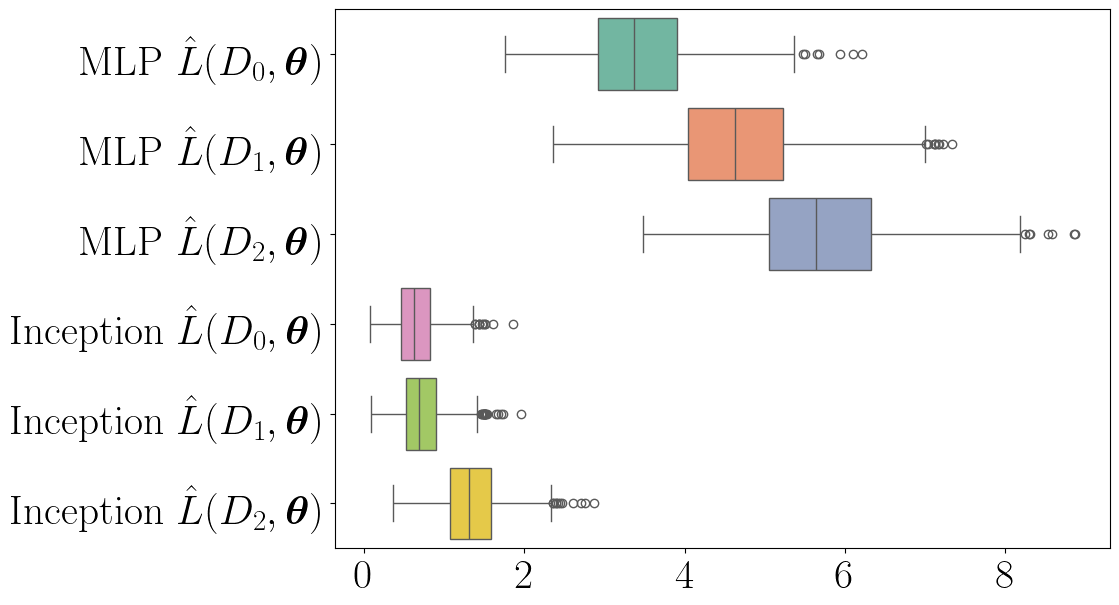

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7)

data = [inception_tc_log_p, inception_t_log_p, inception_log_p, mlp_tc_log_p, mlp_t_log_p, mlp_log_p][::-1]


labels = [r"Inception $\hat{L}(D_2, \bm{\theta})$", r"Inception $\hat{L}(D_1, \bm{\theta})$", r"Inception $\hat{L}(D_0, \bm{\theta})$",
          r"MLP $\hat{L}(D_2, \bm{\theta})$",r"MLP $\hat{L}(D_1, \bm{\theta})$", r"MLP $\hat{L}(D_0, \bm{\theta})$"][::-1]
df = pd.DataFrame(np.array(data).T, columns = labels)

sns.boxplot(data = df, orient = "h", palette = "Set2")
plt.savefig("/content/drive/MyDrive/invariances/Invariance_boxplots.pdf", format = "pdf",bbox_inches='tight')
plt.show()

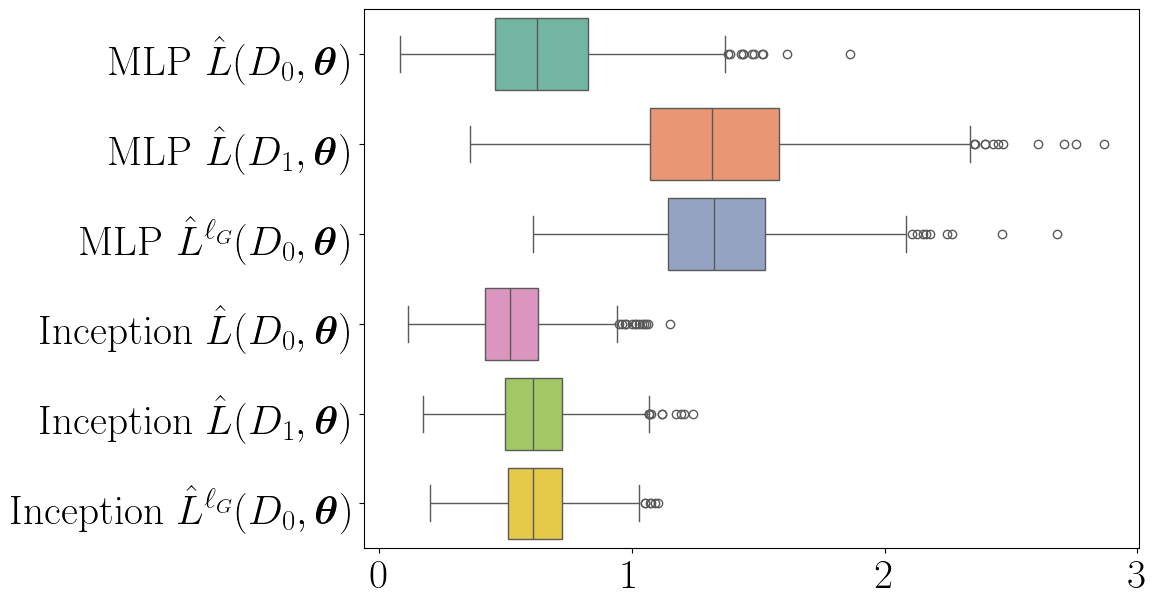

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7)
data = [inception_da_tc_ad_log_p, inception_da_tc_log_p, inception_da_log_p, inception_tc_ad_log_p, inception_tc_log_p, inception_log_p][::-1]


labels = [r"Inception $\hat{L}^{\ell_G}(D_0, \bm{\theta})$",r"Inception $\hat{L}(D_1, \bm{\theta})$", r"Inception $\hat{L}(D_0, \bm{\theta})$",
          r"MLP $\hat{L}^{\ell_G}(D_0, \bm{\theta})$",r"MLP $\hat{L}(D_1, \bm{\theta})$", r"MLP $\hat{L}(D_0, \bm{\theta})$"][::-1]
df = pd.DataFrame(np.array(data).T, columns = labels)

sns.boxplot(data = df, orient = "h", palette = "Set2")

plt.savefig("/content/drive/MyDrive/invariances/Invariance_boxplots_DA.pdf", format = "pdf",bbox_inches='tight')
plt.show()

In [ ]:
def get_log_p(device, model, loader):
    cce = nn.CrossEntropyLoss(reduction = "none") # supervised classification loss
    model.eval()
    aux = []
    with torch.no_grad():
      for data, targets in loader:
          data = data.to(device)
          targets = targets.to(device)
          logits = model(data)
          probs = F.softmax(logits, dim=1)
          log_p = -cce(logits, targets) # supervised loss
          aux.append(log_p)
    return torch.cat(aux)


#Binary Search for lambdas
def rate_function_BS(s_value, log_ps):
  if (s_value<0):
    min_lamb=torch.tensor(-10000).to(device)
    max_lamb=torch.tensor(0).to(device)
  else:
    min_lamb=torch.tensor(0).to(device)
    max_lamb=torch.tensor(10000).to(device)

  s_value=torch.tensor(s_value).to(device)
  #log_p = get_log_p(device, model, loader)
  return aux_rate_function_TernarySearch(log_ps, s_value, min_lamb, max_lamb, 0.001)

def eval_log_p(log_p, lamb, s_value):
  jensen_val=(torch.logsumexp(lamb * log_p, 0) - torch.log(torch.tensor(log_p.shape[0], device = device)) - lamb *torch.mean(log_p))
  return lamb*s_value - jensen_val

def aux_rate_function_TernarySearch(log_p, s_value, low, high, epsilon):

  while (high - low) > epsilon:
    mid1 = low + (high - low) / 3
    mid2 = high - (high - low) / 3

    if eval_log_p(log_p, mid1, s_value) < eval_log_p(log_p, mid2, s_value):
        low = mid1
    else:
        high = mid2

  # Return the midpoint of the final range
  mid = (low + high) / 2
  return [eval_log_p(log_p, mid, s_value).detach().cpu().numpy(), mid.detach().cpu().numpy(), (mid*s_value - eval_log_p(log_p, mid, s_value)).detach().cpu().numpy()]


In [ ]:
s_values = np.arange(0, 0.3, 0.01)


rate_mlp = np.array([rate_function_BS(s,  torch.tensor(mlp_log_p).to(device))[0] for s in s_values])
rate_mlp_t = np.array([rate_function_BS(s, torch.tensor(mlp_t_log_p).to(device))[0] for s in s_values])
rate_mlp_tr = np.array([rate_function_BS(s,  torch.tensor(mlp_tc_log_p).to(device))[0] for s in s_values])

In [ ]:
rate_inception = np.array([rate_function_BS(s,  torch.tensor(inception_log_p).to(device))[0] for s in s_values])
rate_inception_t = np.array([rate_function_BS(s, torch.tensor(inception_t_log_p).to(device))[0] for s in s_values])
rate_inception_tr = np.array([rate_function_BS(s,  torch.tensor(inception_tc_log_p).to(device))[0] for s in s_values])
rate_inception_ad_tr = np.array([rate_function_BS(s,  torch.tensor(inception_tc_ad_log_p).to(device))[0] for s in s_values])

In [ ]:
rate_inception_da = np.array([rate_function_BS(s,  torch.tensor(inception_da_log_p).to(device))[0] for s in s_values])
rate_inception_da_t = np.array([rate_function_BS(s, torch.tensor(inception_da_t_log_p).to(device))[0] for s in s_values])
rate_inception_da_tr = np.array([rate_function_BS(s,  torch.tensor(inception_da_tc_log_p).to(device))[0] for s in s_values])
rate_inception_da_ad_tr = np.array([rate_function_BS(s,  torch.tensor(inception_da_tc_ad_log_p).to(device))[0] for s in s_values])

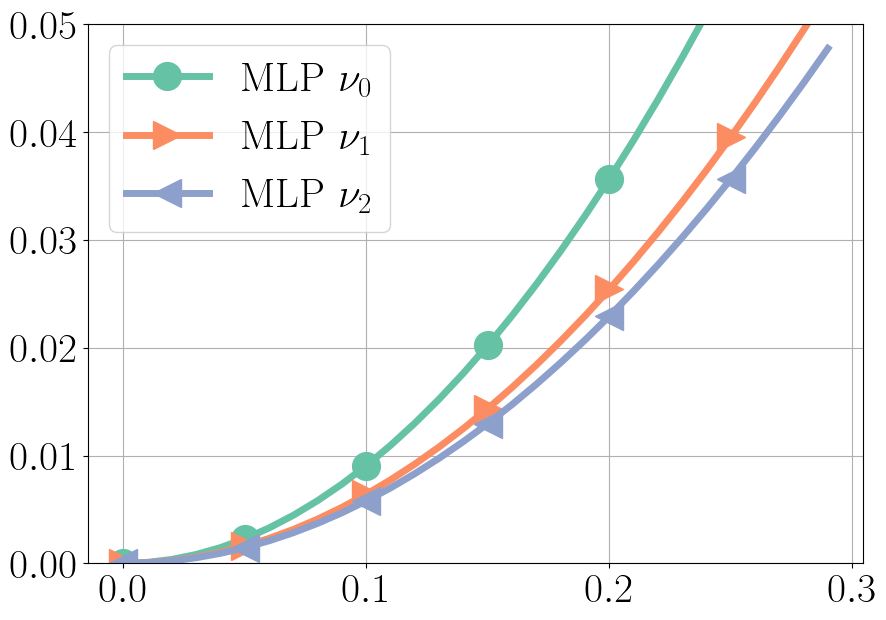

In [ ]:

plt.plot(s_values, rate_mlp, label=r"MLP $\nu_0$",linewidth=5, color = jet(0), marker ="o",  markersize=20, markevery=5)
plt.plot(s_values, rate_mlp_t, label=r"MLP $\nu_1$",linewidth=5,  color = jet(1), marker = ">",  markersize=20, markevery=5)
plt.plot(s_values, rate_mlp_tr, label=r"MLP $\nu_2$",linewidth=5,  color = jet(2), marker = "<",  markersize=20, markevery=5)
plt.legend()
plt.ylim(0,0.05)
plt.grid()
plt.savefig("/content/drive/MyDrive/invariances/Invariance_rate_mlp.pdf", format = "pdf",bbox_inches='tight')

plt.show()

<ipython-input-72-487aa4975869>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.2f}'.format(x) for x in current_values])


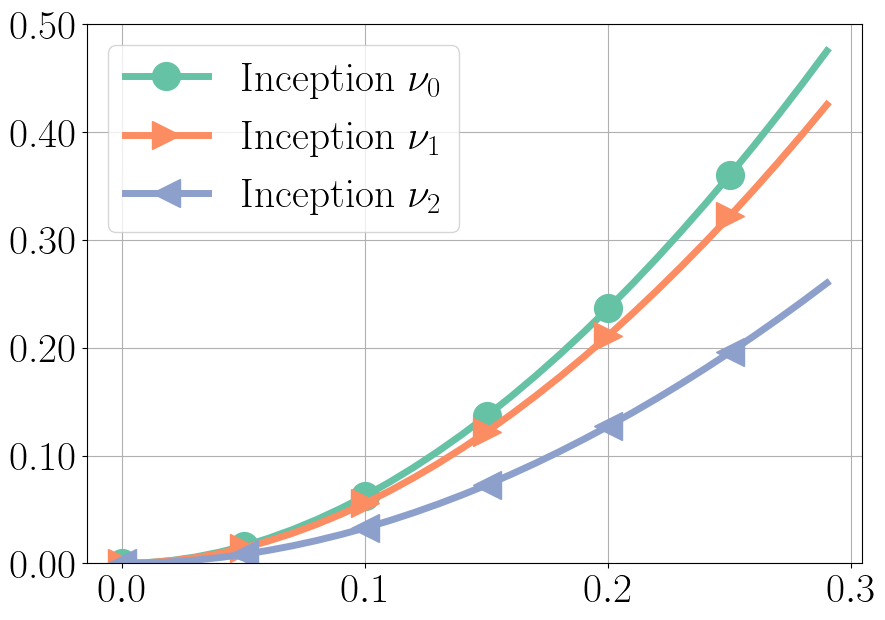

In [ ]:
plt.plot(s_values, rate_inception, label=r"Inception $\nu_0$",linewidth=5, color = jet(0), marker ="o",  markersize=20, markevery=5)
plt.plot(s_values, rate_inception_t, label=r"Inception $\nu_1$",linewidth=5, color = jet(1), marker =">",  markersize=20, markevery=5)
plt.plot(s_values, rate_inception_tr, label=r"Inception $\nu_2$",linewidth=5, color = jet(2), marker ="<",  markersize=20, markevery=5)
plt.legend()
plt.ylim(0,0.5)
plt.grid()
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.2f}'.format(x) for x in current_values])
plt.savefig("/content/drive/MyDrive/invariances/Invariance_rate_inception.pdf", format = "pdf",bbox_inches='tight')

plt.show()

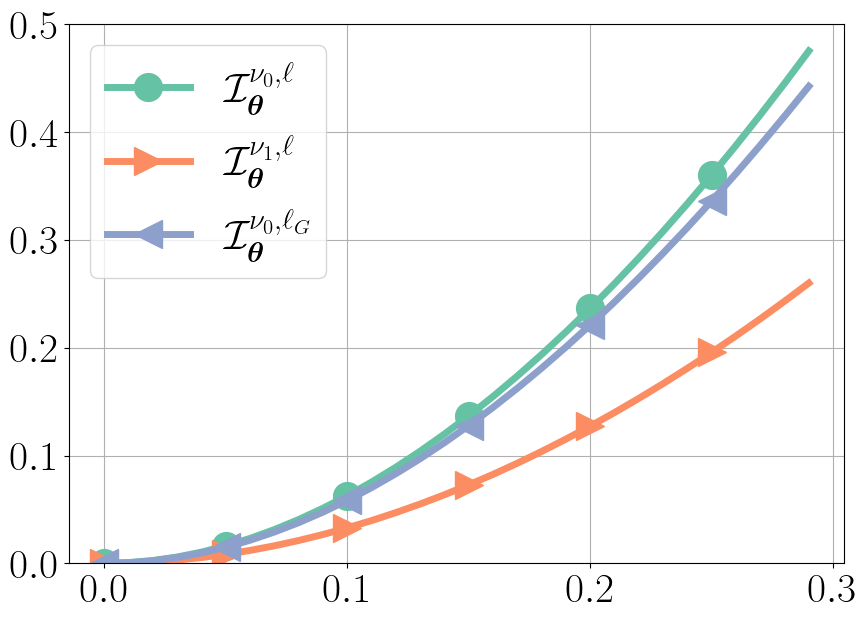

In [ ]:
plt.plot(s_values, rate_inception, label=r"$\mathcal{I}_{\bm{\theta}}^{\nu_0, \ell}$",linewidth=5, color = jet(0), marker ="o",  markersize=20, markevery=5)
plt.plot(s_values, rate_inception_tr, label=r"$\mathcal{I}_{\bm{\theta}}^{\nu_1, \ell}$",linewidth=5, color = jet(1), marker =">",  markersize=20, markevery=5)
plt.plot(s_values, rate_inception_ad_tr, label=r"$\mathcal{I}_{\bm{\theta}}^{\nu_0, \ell_G}$",linewidth=5, color = jet(2), marker ="<",  markersize=20, markevery=5)
plt.legend()
plt.grid()
plt.ylim(0,0.5)
plt.savefig("/content/drive/MyDrive/invariances/Invariance_rate_inception_standard_da.pdf", format = "pdf",bbox_inches='tight')

plt.show()

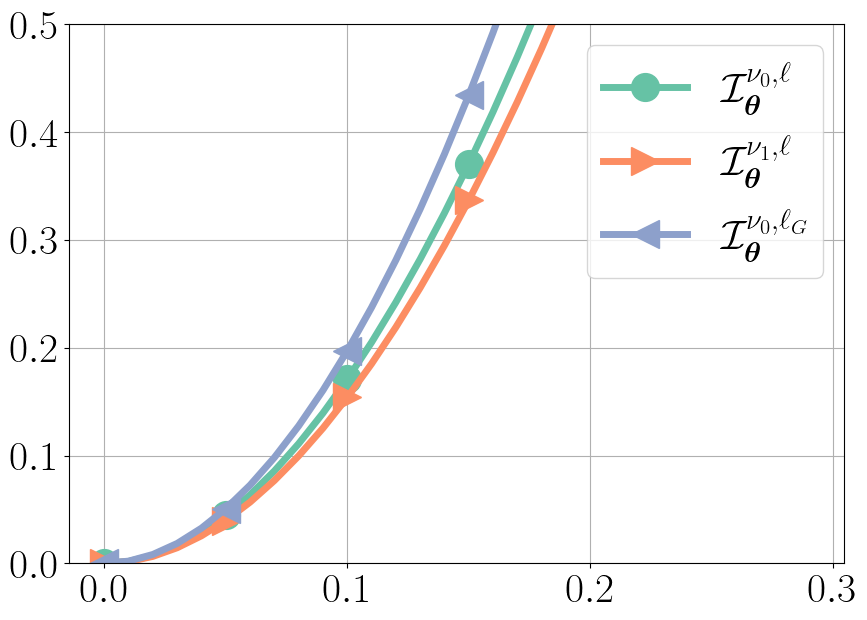

In [ ]:
plt.plot(s_values, rate_inception_da, label=r"$\mathcal{I}_{\bm{\theta}}^{\nu_0, \ell}$",linewidth=5, color = jet(0), marker ="o",  markersize=20, markevery=5)
plt.plot(s_values, rate_inception_da_tr, label=r"$\mathcal{I}_{\bm{\theta}}^{\nu_1, \ell}$",linewidth=5, color = jet(1), marker =">",  markersize=20, markevery=5)
plt.plot(s_values, rate_inception_da_ad_tr, label=r"$\mathcal{I}_{\bm{\theta}}^{\nu_0, \ell_G}$",linewidth=5, color = jet(2), marker ="<",  markersize=20, markevery=5)
plt.legend()
plt.grid()
plt.ylim(0,0.5)
plt.savefig("/content/drive/MyDrive/invariances/Invariance_rate_inception_da_da.pdf", format = "pdf",bbox_inches='tight')

plt.show()